# Import Required Libraries
Import the necessary libraries, including pandas, numpy, lifelines, and matplotlib.

In [8]:
# Time to Event Analysis

## Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.preprocessing import StandardScaler

# Load the Dataset
Load the dataset using pandas and display the first few rows.

In [9]:
# Load dataset
df = pd.read_csv("data_censored.csv")

# Define column names (ensure these match your dataset!)
duration_col = "period"  # Replace with actual time column name
event_col = "censored"   # Replace with actual event column (1=event occurred, 0=censored)

# Check column names
if duration_col not in df.columns or event_col not in df.columns:
    raise ValueError(f"ERROR: Column names are incorrect! Check: {df.columns}")

# Convert to numeric (if necessary)
df[duration_col] = pd.to_numeric(df[duration_col], errors="coerce")
df[event_col] = pd.to_numeric(df[event_col], errors="coerce")

# Data Preprocessing
Handle missing values, encode categorical variables, and prepare the data for analysis.

In [10]:
# Standardize the data
scaler = StandardScaler()
df[df.columns.difference([duration_col, event_col])] = scaler.fit_transform(df[df.columns.difference([duration_col, event_col])])

# Check for multicollinearity
correlation_matrix = df.corr()
print(correlation_matrix)

# Remove highly correlated features
threshold = 0.9  # Set your threshold for high correlation
high_corr_vars = [column for column in correlation_matrix.columns if any(correlation_matrix[column] > threshold) and column != duration_col and column != event_col]
df = df.drop(columns=high_corr_vars)

                 id    period  treatment        x1        x2        x3  \
id         1.000000  0.024945  -0.031034  0.027401 -0.019298 -0.015944   
period     0.024945  1.000000  -0.160336  0.038273 -0.058948 -0.044744   
treatment -0.031034 -0.160336   1.000000  0.053655  0.120555  0.021803   
x1         0.027401  0.038273   0.053655  1.000000  0.072324 -0.034552   
x2        -0.019298 -0.058948   0.120555  0.072324  1.000000 -0.067664   
x3        -0.015944 -0.044744   0.021803 -0.034552 -0.067664  1.000000   
x4        -0.047173 -0.143004   0.431029 -0.113441 -0.039730  0.189442   
age        0.066729  0.569833  -0.236510  0.040720  0.002637 -0.135130   
age_s      0.066729  0.569833  -0.236510  0.040720  0.002637 -0.135130   
outcome    0.042941 -0.014715  -0.048474 -0.010587  0.024623  0.037117   
censored  -0.010342 -0.228819   0.049726 -0.077869  0.122761  0.017903   
eligible   0.004708 -0.510754  -0.042344  0.060087  0.074121  0.079643   

                 x4       age     age

# Exploratory Data Analysis
Perform exploratory data analysis to understand the distribution of the data and visualize key features.

           period   censored
count  725.000000  725.00000
mean     7.051034    0.08000
std      5.802351    0.27148
min      0.000000    0.00000
25%      2.000000    0.00000
50%      6.000000    0.00000
75%     12.000000    0.00000
max     19.000000    1.00000


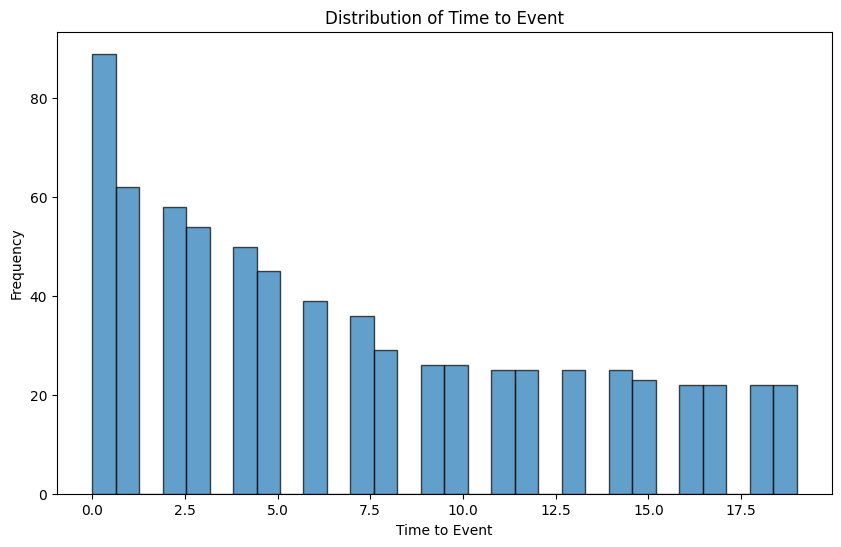

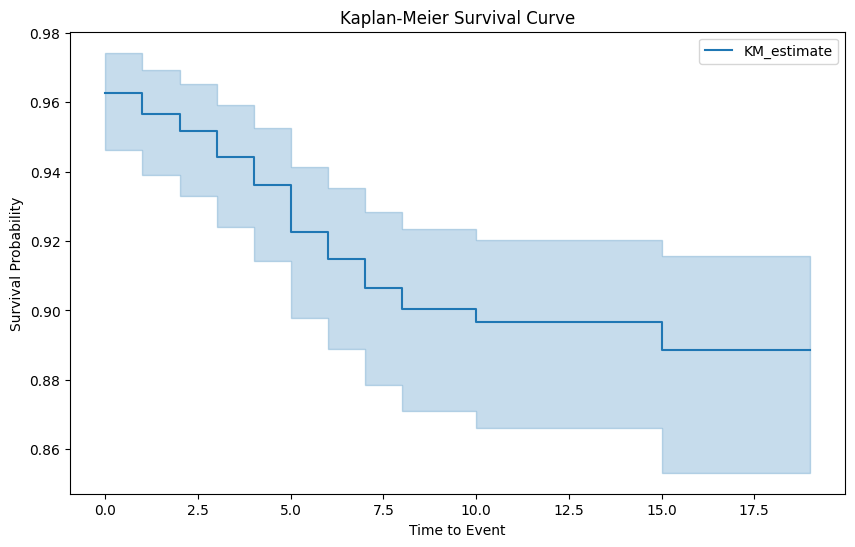

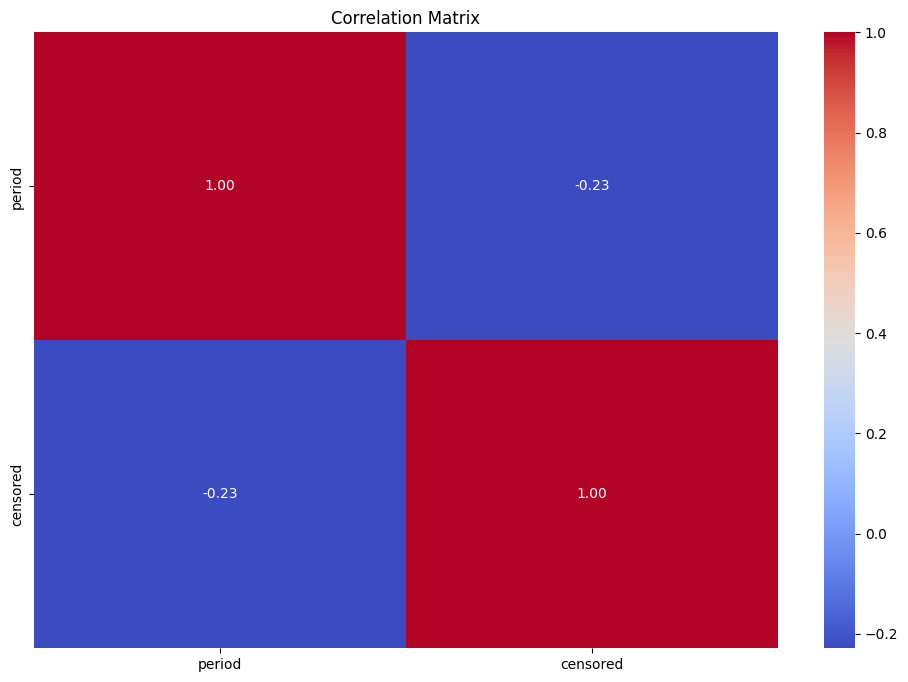

In [11]:
# Summary statistics of the dataset
summary_stats = df.describe()
print(summary_stats)

# Distribution of the target variable (Time to Event)
plt.figure(figsize=(10, 6))
plt.hist(df[duration_col], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Time to Event')
plt.xlabel('Time to Event')
plt.ylabel('Frequency')
plt.show()

# Kaplan-Meier survival curve
kmf = KaplanMeierFitter()
kmf.fit(durations=df[duration_col], event_observed=df[event_col])

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time to Event')
plt.ylabel('Survival Probability')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Pairplot of key features
# key_features = ['treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', duration_col]
# sns.pairplot(df[key_features], diag_kind='kde')
# plt.show()

# Kaplan-Meier Estimator
Use the Kaplan-Meier estimator to estimate the survival function and plot the survival curve.

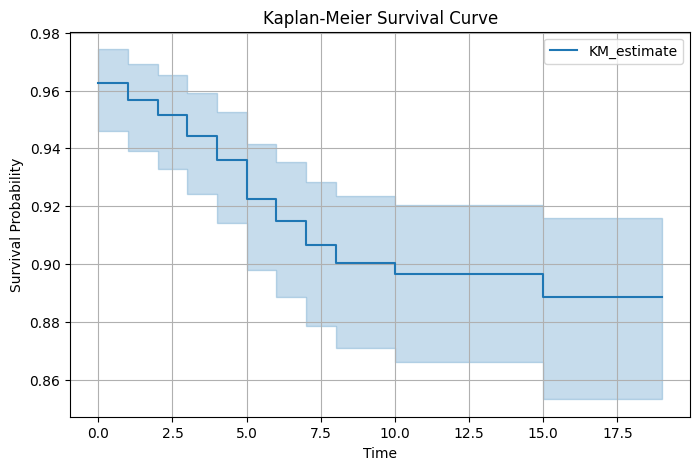

In [12]:
# Kaplan-Meier Survival Analysis
kmf = KaplanMeierFitter()
kmf.fit(df[duration_col], event_observed=df[event_col])

# Plot Kaplan-Meier curve
plt.figure(figsize=(8, 5))
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid()
plt.show()

# Cox Proportional Hazards Model
Fit a Cox proportional hazards model to the data and interpret the results.

model,lifelines.CoxPHFitter
duration col,'period'
event col,'event'
penalizer,0.1
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,725
number of events observed,58
partial log-likelihood,-244.92
time fit was run,2025-03-09 13:48:56 UTC


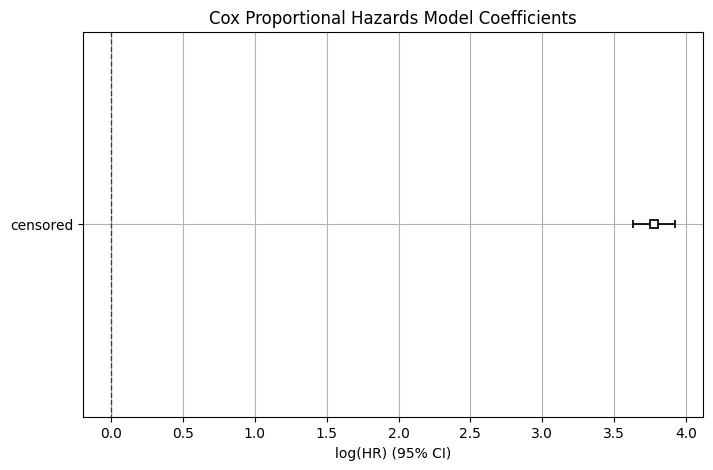

In [13]:
# Cox Proportional-Hazards Model
cph = CoxPHFitter(penalizer=0.1)
df["event"] = df[event_col]  # Ensure lifelines compatibility

# Fit Cox model
cph.fit(df, duration_col=duration_col, event_col="event", robust=True)

# Show summary
cph.print_summary()

# Plot Cox model survival function
plt.figure(figsize=(8, 5))
cph.plot()
plt.title("Cox Proportional Hazards Model Coefficients")
plt.grid()
plt.show()

### Kaplan-Meier Survival Analysis
1. **Kaplan-Meier Curve**: The Kaplan-Meier curve provides a visual representation of the survival probability over time. The curve shows the proportion of subjects surviving at each time point. A steep drop in the curve indicates a higher event rate at that time.

### Cox Proportional-Hazards Model
1. **Coefficients and Hazard Ratios**:
   - The `coef` column represents the log hazard ratios for each variable.
   - The `exp(coef)` column represents the hazard ratios. A hazard ratio greater than 1 indicates an increased risk of the event occurring, while a hazard ratio less than 1 indicates a decreased risk.
   - For the `censored` variable, the hazard ratio is 43.81, which suggests a very high risk associated with this variable.

2. **Statistical Significance**:
   - The `p` value for the `censored` variable is `<0.005`, indicating that this variable is statistically significant in predicting the event.
   - The `z` value is 51.32, which is quite high, further confirming the significance of the `censored` variable.

3. **Model Fit**:
   - The `Concordance` index is 0.98, which indicates a very good fit of the model. A concordance index closer to 1 suggests that the model has a high predictive accuracy.
   - The `Partial AIC` is 491.85, which is a measure of the model's goodness of fit. Lower AIC values indicate a better fit.
   - The `log-likelihood ratio test` value is 238.95 with a `-log2(p)` of 176.65, indicating that the model is statistically significant.

### Multicollinearity
1. **Correlation Matrix**:
   - The correlation matrix shows the pairwise correlations between variables. High correlations (close to 1 or -1) between independent variables can indicate multicollinearity, which can affect the stability of the model coefficients.
   - Variables like `age` and `age_s` have a perfect correlation (1.000), suggesting that one of them should be removed to avoid multicollinearity.

### Recommendations
1. **Variable Selection**:
   - Consider removing one of the highly correlated variables (`age` or `age_s`) to reduce multicollinearity.
   - Re-evaluate the inclusion of variables with high hazard ratios and statistical significance.

2. **Model Interpretation**:
   - Focus on the variables with significant p-values and high hazard ratios for further analysis and interpretation.
   - Investigate the `censored` variable further, as it has a very high hazard ratio and is statistically significant.

3. **Further Analysis**:
   - Perform additional diagnostics to check the proportional hazards assumption.
   - Consider using other survival analysis techniques or models if necessary.

By following these recommendations, you can refine your analysis and gain deeper insights into the factors affecting the survival probability in your dataset.